# 03_DetectOpening

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

from metpy.calc import wind_components
from metpy.units import units

import gsw
import gsw.freezing

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

sys.path.append('../')
import plot_simply.geomap as geomap
import data_UniBremen.SIC as UNISIC


In [2]:
from skimage.morphology import flood
from skimage.segmentation import find_boundaries
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes

In [3]:
def return_indices(polynya_flooded, ii, jj, ii_size, jj_size):
    
    ii_l = ii-ii_size
    ii_r = ii+ii_size+1
    jj_l = jj-jj_size
    jj_r = jj+jj_size+1
    
    # adjust bounds for footprint edge conditions
    if ii_l < 0:
        ii_l_f = -ii_l
        ii_l = 0
    else:
        ii_l_f = 0

    if jj_l < 0:
        jj_l_f = -jj_l
        jj_l = 0
    else:
        jj_l_f = 0   

    if ii_r >= polynya_flooded.shape[0]:
        ii_r_f = polynya_flooded.shape[0]-ii_r
        ii_r = polynya_flooded.shape[0]
    else:
        ii_r_f = 1+2*ii_size

    if jj_r >= polynya_flooded.shape[1]:
        jj_r_f = polynya_flooded.shape[1]-jj_r
        jj_r = polynya_flooded.shape[1]
    else:
        jj_r_f = 1+2*jj_size
        
    return ii_l, ii_r, jj_l, jj_r, ii_l_f, ii_r_f, jj_l_f, jj_r_f

def grab_footprint(foot, polynya_flooded, keys, ii, jj, ii_size, jj_size):
            
    out = return_indices(polynya_flooded, ii, jj, ii_size, jj_size)
    ii_l, ii_r, jj_l, jj_r, ii_l_f, ii_r_f, jj_l_f, jj_r_f = out

    # crop footprint
    foot = foot[ii_l_f:ii_r_f, jj_l_f:jj_r_f]

    # crop to local values, and return those within footprint
    nearby_vals = polynya_flooded[ii_l:ii_r, jj_l:jj_r][foot]
    
    nearby_keys = keys[ii_l:ii_r, jj_l:jj_r][foot]

    return nearby_vals, nearby_keys


### Open sample file

In [4]:
# date = datetime(2018,1,15)

date = datetime(2018,2,11)
sic = UNISIC.open_local_file(pd.to_datetime(date), res='6250', hem='n', 
                                 main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                             crop=[875,1000,256,350],
                                 coordinates=True, area=True, include_units=False, 
                                 quiet=True)


### specify sic thresh and initialization points

In [5]:
#==================
thresh = 30
#==================

# ia, ib = (8,13)
# ja, jb = (7,12)
# jgrid, igrid = np.meshgrid(np.arange(ja, jb), np.arange(ia, ib))

# grid of indices
keys = np.arange(np.shape(sic['xx'])[0]*np.shape(sic['xx'])[1]).reshape(np.shape(sic['xx'])[0], np.shape(sic['xx'])[1])


# create 50 km radius footprint to check
#==================
radius = 8
#==================
footprint = disk(radius).astype(bool)
ii_size = int((footprint.shape[0]-1)/2)
jj_size = int((footprint.shape[1]-1)/2)

radius_in_km = radius * np.diff(sic['xx'], axis=1)[0][0] / 1000
print(f'r = {radius_in_km} km')

r = 50.0 km


## Define orientations along/against polynya axis

In [6]:
import pyproj

# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
bearing1 = -45
#==================
bearing2 = bearing1+90
bearing3 = bearing1-90
distance = 10000 # m

geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

reg_lons = np.array([-139])
reg_lats = np.array([69.6])

reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(80):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
for ss in range(60):
    lon2, lat2, _ = geod.fwd(reg_lonsp[-1], reg_latsp[-1], bearing2, distance)
    reg_lonsp = np.append(reg_lonsp, lon2)
    reg_latsp = np.append(reg_latsp, lat2)
    
for ss in range(60):
    lon2, lat2, _ = geod.fwd(reg_lonsp[0], reg_latsp[0], bearing3, distance)
    reg_lonsp = np.append(np.array([lon2]), reg_lonsp)
    reg_latsp = np.append(np.array([lat2]), reg_latsp)
    
reg_lons[reg_lons<0]+=360
reg_lonsp[reg_lonsp<0]+=360

axis = {}
axis['lon'] = reg_lons
axis['lat'] = reg_lats

axisP = {}
axisP['lon'] = reg_lonsp
axisP['lat'] = reg_latsp

for group in [axis, axisP]:
    out = sic['proj'].transform_points(ccrs.PlateCarree(), group['lon'], group['lat'])
    group['xx'] = out[:,0]
    group['yy'] = out[:,1]
    


## Calc distances along/against polynya axis

In [7]:
axis_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axis_dist)[0]):
    for jj in range(np.shape(axis_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axisP['xx']
        dy = sic['yy'][ii,jj] - axisP['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] > 0):
            sign = 1
        
        axis_dist[ii,jj] = sign * np.min(dist2)

axis_dist = axis_dist / 1000 # km

        
axisP_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axisP_dist)[0]):
    for jj in range(np.shape(axisP_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axis['xx']
        dy = sic['yy'][ii,jj] - axis['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] < 0):
            sign = 1
        
        axisP_dist[ii,jj] = sign * np.min(dist2)

axisP_dist = axisP_dist / 1000 # km


axisP_dist = np.full(sic['sic'].shape, np.nan)

for ii in range(np.shape(axisP_dist)[0]):
    for jj in range(np.shape(axisP_dist)[1]):
        
        dx = sic['xx'][ii,jj] - axis['xx']
        dy = sic['yy'][ii,jj] - axis['yy']
        
        dist2 = np.sqrt(dx**2 + dy**2)
        closest = np.argmin(dist2)
        
        sign = -1
        if (dx[closest] > 0) & (dy[closest] < 0):
            sign = 1
        
        axisP_dist[ii,jj] = sign * np.min(dist2)

axisP_dist = axisP_dist / 1000 # km

HI_dist = np.sqrt((sic['xx']-axis['xx'][0])**2 + (sic['yy']-axis['yy'][0])**2) / 1000 # km



# find initial points within 50 km of the island
land_current = np.isnan(sic['sic'])
initial_points = ((HI_dist<50) & (axis_dist>0))&(land_current==False)
ni, nj = np.where(initial_points)


<IPython.core.display.Javascript object>


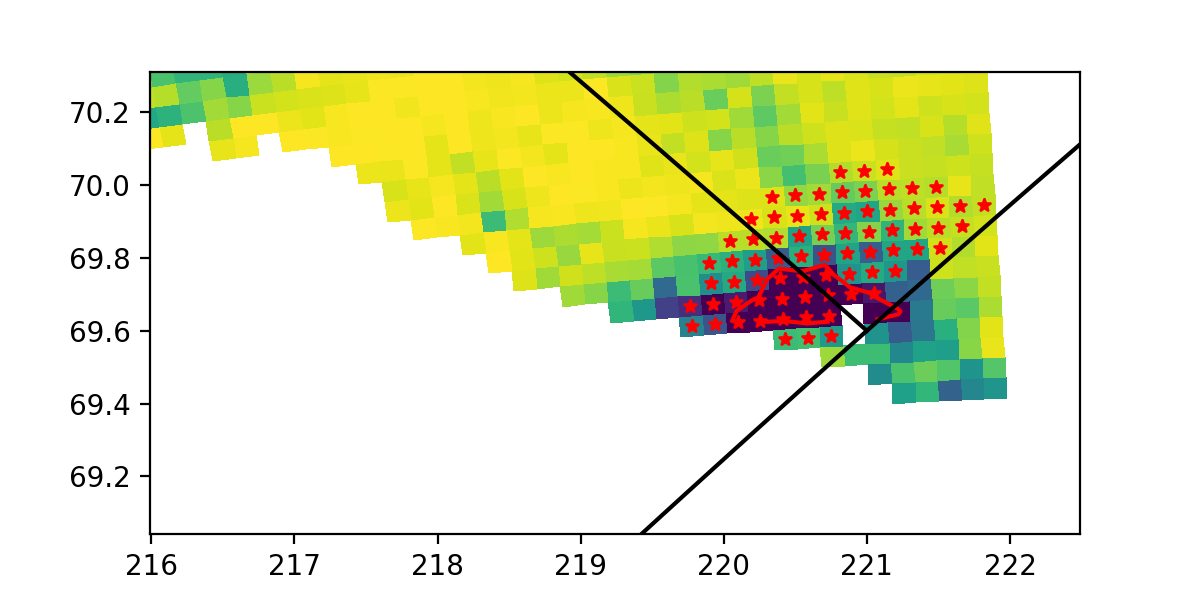

In [8]:
%matplotlib notebook
fig, ax= plt.subplots(figsize=(6,3))
ax.set_ylim(69,73)
plt.xlim(198,222)

# fig, ax= plt.subplots()

X = 'lon'
Y = 'lat'

plt.pcolormesh(sic[X], sic[Y], sic['sic'], vmin=thresh, vmax=100)


plt.contour(sic[X], sic[Y], sic['sic'], levels=[thresh], colors=['r'])


plt.plot(axis[X], axis[Y], c='k')
plt.plot(axisP[X], axisP[Y], c='k')

# plt.pcolormesh(sic[X], sic[Y], HI_dist, vmin=-100, vmax=100, cmap=cmocean.cm.balance)

ax.scatter(sic[X][ni,nj], sic[Y][ni,nj], c='r', marker='*', s=20)
# ax.scatter(sic[X][ia:ib, ja:jb], sic[Y][ia:ib, ja:jb], c='k', marker='*', s=5)



## Run calculation!

In [11]:

#============================================================
dates = pd.date_range(datetime(2018,11,1), datetime(2019,6,1))

#============================================================


char = {}

char['N'] = np.array([])
char['extent'] = np.array([])

orientations = ['l', 'w']
percentiles = [5,25,50,75,95]


for o in orientations:
    char[f'{o}_min'] = np.array([])
    char[f'{o}_max'] = np.array([])
    char[f'{o}_mean'] = np.array([])
    
    for per in percentiles:
        char[f'{o}_per{per}'] = np.array([])

In [14]:


for date in dates:
    
    
    try:
        sic = UNISIC.open_local_file(pd.to_datetime(date), res='6250', hem='n', 
                                     main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                     crop=[875,1000,256,350], coordinates=True, area=True, 
                                     include_units=False,  quiet=True)    
    except:
        for key in char.keys():
            char[key] = np.append(char[key], np.nan)
            
    else:

        # binarize
        polynyas = np.copy((sic['sic'] < thresh) & (axis_dist > 0))

        # if no polynya present, save zeros
        if np.sum(polynyas[ni,nj]) == 0:
            for key in char.keys():
                char[key] = np.append(char[key], 0)
        
        # if polynya present, find its size
        else:
            
            size = [0]
            counter = 0

            # find indices of polynya points intersecting initialization points

            
            polynya_keys = keys[ni,nj][polynyas[ni,nj]]
            i_pol, j_pol = np.where(keys == polynya_keys[0]) # grab first key and start from there

#             i_pol = igrid[polynyas[ia:ib,ja:jb]]
#             j_pol = jgrid[polynyas[ia:ib,ja:jb]]

            # flood
            polynya_flood = flood(polynyas.astype(int), (i_pol[0], j_pol[0]), connectivity=2)

            size.append(np.sum(polynya_flood)) # record current size

            # while polynya size keeps changing, iterate and add new adjacent points
            while size[-1] != size[-2]:

                counter+=1
                if counter > 100:
                    break

                # find edges of polynya and ice
                polynya_edge = find_boundaries(polynya_flood, mode='inner').astype(int)

                # iterate over polynya edges and find new points to add
                ci, cj = np.where(polynya_edge)

                for ii, jj in zip(ci, cj):

                    # find adjacent polynya cells within radius of polynya edge point
                    footvals, footkeys = grab_footprint(footprint, polynyas.astype(int), keys, ii, jj, ii_size, jj_size)

                    # update polynya
                    for key in footkeys[footvals==1]:
                        polynya_flood[np.where(keys == key)] = True

                size.append(np.sum(polynya_flood)) # update size
                
            N = np.sum(polynya_flood)
            extent = np.sum(sic['area'][polynya_flood])

            char['N'] = np.append(char['N'], N)
            char['extent'] = np.append(char['extent'], extent)

            for d, group in zip(['l', 'w'], [axis_dist, axisP_dist]):

                dmin = np.min(group[polynya_flood])
                dmax = np.max(group[polynya_flood])
                dmean = np.mean(group[polynya_flood])

                char[f'{d}_min'] = np.append(char[f'{d}_min'], dmin)
                char[f'{d}_max'] = np.append(char[f'{d}_max'], dmax)
                char[f'{d}_mean'] = np.append(char[f'{d}_mean'], dmean)


                for per in percentiles:
                    perc = np.percentile(group[polynya_flood], per)
                    char[f'{d}_per{per}'] = np.append(char[f'{d}_per{per}'], perc)


### Save to NC

In [15]:


data_vars = {}

for key in list(char.keys()):
    
    # build long name
    if 'w' in key:
        dim = 'width'
    elif 'l' in key:
        dim = 'length'
    else:
        dim = 'total'
        
    if '_' in key:
        more = key.split('_')[1]
        if 'per' in more:
            more = f"{more.split('per')[1]}th percentile" 
    else:
        more = key
        
    long_name = f'{more} {dim}'

    # set units
    if key =='N':
        units="6.25 km cells"
    else:
        units = 'km'
    
    # construct data field
    data_vars[key] = (("time"), char[key], {'long_name': long_name, 'units': units})

ds = xr.Dataset(data_vars, coords={"time": dates})   

# save to file
mainpath = './data/polynya_size/'
filename = f"daily_polynya_{dates[-1].year}_v0.nc"
ds.to_netcdf(mainpath+filename)


<IPython.core.display.Javascript object>


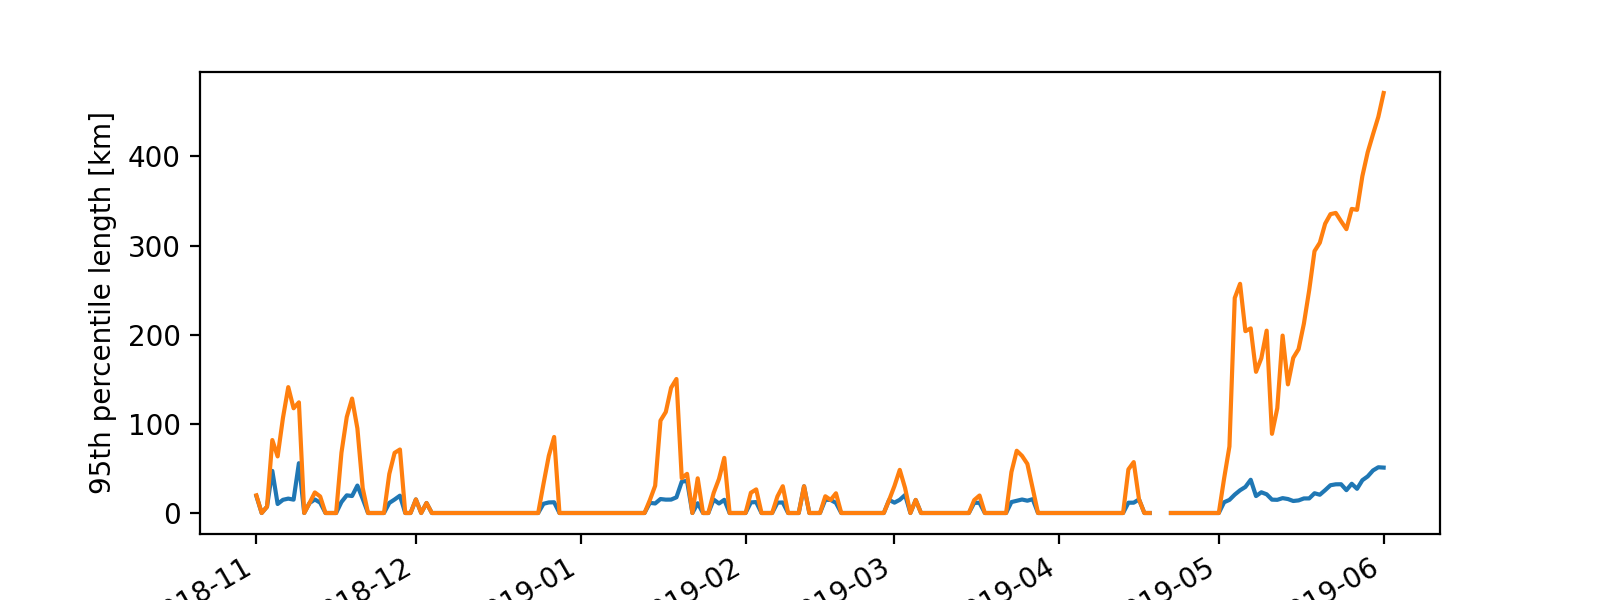

In [16]:
fig, ax= plt.subplots(figsize=(8,3))
ds.l_per5.plot()
ds.l_per95.plot()
